In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from generater import ChangableBC, BC, Domain

import pickle
import os

In [2]:
class mynet(nn.Module):
    def __init__(self,act):
        super(mynet,self).__init__()

        self.main_node = [2,5,10,30,50,30,10,5,3,1]

        self.activate = act

        sum_of_node = 0
        for i in self.main_node:
            sum_of_node += i

        self.BCNet = nn.Sequential(
            nn.Linear(4*10*3,50),
            nn.Tanh(),
            nn.Linear(50,10),
            nn.Tanh(),
            nn.Linear(10,len(self.main_node) - 1)
        )

        layer_list = []

        for i,j in zip(self.main_node[:-1],self.main_node[1:]):
            layer_list.append(nn.Linear(i + 1,j))

        self.mainNet = nn.ModuleList(layer_list)
    
    def forward(self,x):
        x_for_main = x[:,:2]
        x_for_BC = x[:,2:]

        additional_input = self.BCNet(x_for_BC)


        input = x_for_main
        start = 0
        end = self.main_node[0]


        for i,layer in enumerate(self.mainNet):
            input = torch.hstack((input,additional_input[:,i].view(-1,1)))
            input = layer(input)
            input = self.activate(input)

            # start += self.main_node[i]
            # end += self.main_node[i+1]

        return input

In [3]:
num_train = 1000
num_test = 100

train_dataset = ChangableBC(Domain([0,0.01],[0,0.01]),
                            n_data = num_train,
                            num_each_bc = 10,
                            max_noize = 20).set_BC_value(up=[500,'value'],
                                                         down=[300,'value'],
                                                         right=[300,'value'],
                                                         left=[300,'value'])
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

test_dataset = BC(Domain([0,0.01],[0,0.01]),
                    n_data = num_test,
                    num_each_bc = 10).set_BC_value(up=[490,'value'],
                                                    down=[315,'value'],
                                                    right=[360,'value'],
                                                    left=[270,'value'])
test_dataloader = DataLoader(test_dataset, batch_size = 8 , shuffle=True)

In [4]:
model = mynet(torch.nn.LeakyReLU())
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

checkpoint_path = 'model_test_checkpoint.pth'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_ = checkpoint['epoch']
else:
    epoch_ = 0

In [6]:
def equation(net,input):
    x = input[:,0].view(-1,1)
    y = input[:,1].view(-1,1)
    space = torch.hstack([x,y])
    T = net(torch.hstack((space,input[:,2:])))
    dTdx = torch.autograd.grad(T,x,torch.ones_like(T),create_graph=True)[0]
    dTdy = torch.autograd.grad(T,y,torch.ones_like(T),create_graph=True)[0]
    ddTddx = torch.autograd.grad(dTdx,x,torch.ones_like(dTdx),retain_graph=True)[0]
    ddTddy = torch.autograd.grad(dTdy,y,torch.ones_like(dTdy),retain_graph=True)[0]
    
    return ddTddx + ddTddy

In [ ]:
num_epoch = 10000
verbose = 10

history = []

for epoch in range(epoch_ + 1,epoch_ + num_epoch + 1):
    Total_Loss = 0
    Total_data_size = 0

    for domain_data, labels in train_dataloader:
        optimizer.zero_grad()

        BC_data, interior_data = domain_data
        Residual_label, BC_label = labels

        BC_pred = model(BC_data)
        BC_loss = loss_fn(BC_pred, BC_label)

        Residual_pred = equation(model,interior_data)
        Residual = loss_fn(Residual_pred, Residual_label)

        total_loss = BC_loss + Residual
        Total_Loss += total_loss * len(BC_data)
        Total_data_size += len(BC_data)

        total_loss.backward()
        optimizer.step()
        print("iteration : {:.4f} %".format(Total_data_size / num_train * 100),end = '\r')

    Total_Loss /= Total_data_size
    if(epoch%verbose==0):
        print(f"Epoch : [{epoch}/{epoch_ + num_epoch}], Loss : {Total_Loss:.4f}")

    history.append([epoch,Total_Loss])

    torch.save({
        'epoch':epoch,
        'model_state_dict':model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict()
    },checkpoint_path)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
history_array = np.array([[i,j.data.item()] for i,j in history])

e = history_array[:,0]
l = history_array[:,1]

plt.plot(e,l)


In [ ]:
test = BC(Domain([0,0.01],[0,0.01]),
        n_data = 1000,
        num_each_bc = 10).set_BC_value(up=[500,'value'],
                                        down=[300,'value'],
                                        right=[300,'value'],
                                        left=[300,'value'])

test_loader = DataLoader(test,batch_size = 100)

In [ ]:
Total_Loss = 0
Total_data_size = 0

coordinate=[]
Temp = []

for domain_data, labels in test_loader:
    optimizer.zero_grad()

    BC_data, interior_data = domain_data
    Residual_label, BC_label = labels

    coordinate.append(BC_data[:,:2])
    coordinate.append(interior_data[:,:2])

    BC_pred = model(BC_data)
    BC_loss = loss_fn(BC_pred, BC_label)

    Residual_pred = equation(model,interior_data)
    Residual = loss_fn(Residual_pred, Residual_label)


    total_loss = BC_loss + Residual
    Total_Loss += total_loss * len(BC_data)
    Total_data_size += len(BC_data)

Total_Loss /= Total_data_size
print(f"Loss : {Total_Loss:.4f}")

In [8]:
bc_sub_domain = np.linspace(0,0.01,10+2)[1:-1]
bc_down_domain = np.array([[i,0] for i in bc_sub_domain],dtype=np.float32)
bc_down_label = np.ones_like(bc_down_domain[:,0],dtype=np.float32) * 300
bc_up_domain = np.array([[i,0.01] for i in bc_sub_domain],dtype=np.float32)
bc_up_label = np.ones_like(bc_up_domain[:,0],dtype=np.float32) * 500
bc_right_domain = np.array([[0.01,i] for i in bc_sub_domain],dtype=np.float32)
bc_right_label = np.ones_like(bc_right_domain[:,0],dtype=np.float32) * 300
bc_left_domain = np.array([[0,i] for i in bc_sub_domain],dtype=np.float32)
bc_left_label = np.ones_like(bc_left_domain[:,0],dtype=np.float32) * 300
bc_domain = np.vstack([bc_down_domain,bc_up_domain,bc_right_domain,bc_left_domain])
bc_label = np.vstack([bc_down_label,bc_up_label,bc_right_label,bc_left_label]).reshape(-1,1)

bc_data = np.hstack([bc_domain,bc_label]).reshape(1,-1)

interior_domain = np.array([[i,j]for i in np.linspace(0,0.01,10+2)[1:-1] for j in np.linspace(0,0.01,10+2)[1:-1]],dtype=np.float32)
bc_data = np.tile(bc_data,(interior_domain.shape[0],1))

test_data = torch.from_numpy(np.hstack([interior_domain,bc_data]))
test_data.shape

torch.Size([100, 122])

In [9]:
temp_field = model(test_data)
pred_data = torch.hstack([test_data[:,:2],temp_field])

In [10]:
space = pred_data[:,:2] * 1100
index = np.array([[int(i)-1,int(j)-1] for i,j in space])
temp = np.zeros([10,10])

for u,[i,j] in enumerate(index):
    temp[i][j] = pred_data[u][2]

temp

array([[299.98074341, 299.98086548, 299.98104858, 299.98123169,
        299.98141479, 299.9815979 , 300.02713013, 300.0017395 ,
        299.97628784, 299.95083618],
       [299.9838562 , 299.98403931, 299.98422241, 299.98440552,
        299.98458862, 299.98471069, 300.03030396, 300.00485229,
        299.97946167, 299.95401001],
       [299.98696899, 299.9871521 , 299.98733521, 299.98751831,
        299.98770142, 299.98788452, 300.03347778, 300.00802612,
        299.98251343, 299.9571228 ],
       [299.99014282, 299.99026489, 299.990448  , 299.9906311 ,
        299.99075317, 299.99093628, 300.03659058, 300.01119995,
        299.98574829, 299.96029663],
       [299.99319458, 299.99337769, 299.99356079, 299.99368286,
        299.99386597, 299.99404907, 300.0397644 , 300.01431274,
        299.98892212, 299.96340942],
       [299.99624634, 299.99649048, 299.99667358, 299.99685669,
        299.99703979, 299.99716187, 300.0428772 , 300.01748657,
        299.99203491, 299.96664429],
       [29

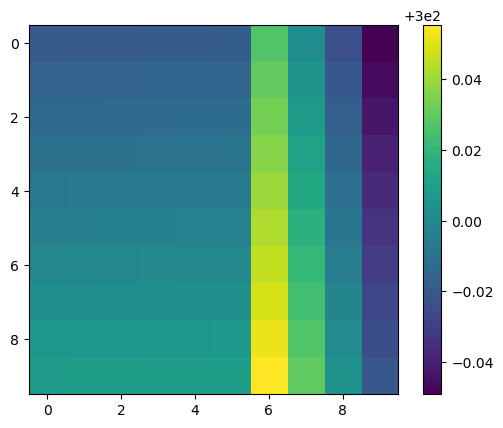

In [11]:
plt.imshow(temp)
plt.colorbar()

In [ ]:
import torch

In [ ]:
torch.rand()

In [ ]:
1 + 2 * torch.rand(1,1)

In [ ]:
a = torch.Tensor([[1,3],[2,4],[3,6]])
a.view(1,-1)

In [ ]:
x, y =torch.meshgrid(torch.linspace(0,1,3),torch.linspace(0,1,3))
torch.hstack([x.reshape(-1,1),y.reshape(-1,1)])

In [ ]:
torch.linspace(0,1,5)

In [ ]:
from math import floor

def g(n):
    x, y = torch.meshgrid(torch.linspace(0,1,floor(n**0.5)+3)[1:-1],torch.linspace(0,1,floor(n**0.5) + 3)[1:-1])
    return torch.hstack([x.reshape(-1,1),y.reshape(-1,1)])[:n,:]
g(13)

In [ ]:
a = torch.arange(0,16).reshape(4,4)
a.flatten()

In [ ]:
a = torch.Tensor([1,2,3,4,5])
b = torch.Tensor([4,5])
torch.hstack([a,b])

In [ ]:
a[torch.randperm(a.size(0))]

In [2]:
import data
from data import Condition, gen

In [3]:
C = Condition(x_min = 0,
              x_max = 1,
              y_min = 0,
              y_max = 1,
              num_each_bc = 4)

d = gen(condition=C,
        n_data = 5,
        mode = 0,
        BC_values={'up':1,'down':2,'right':3,'left':4})

c:\Users\xowls\anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
IN_cord,BC_input,BC_cord,BC_label = d[4]

In [7]:
IN_cord,BC_cord,BC_label

(tensor([0.5000, 0.5000], grad_fn=<SelectBackward0>),
 tensor([0.0000, 0.6000], grad_fn=<SliceBackward0>),
 tensor(4., grad_fn=<SelectBackward0>))

In [1]:
import torch
import matplotlib.pyplot as plt

torch.Size([100, 100]) torch.Size([100, 100]) torch.Size([100, 100])


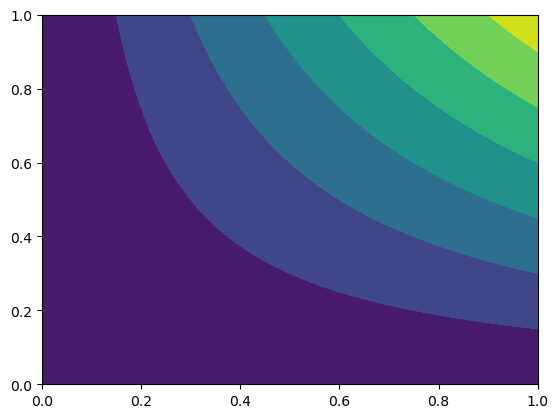

In [4]:
x = torch.linspace(0,1,100)
y = torch.linspace(0,1,100)

def f(x,y):
    return x*y

x,y = torch.meshgrid(x,y,indexing='ij')
z = f(x,y)

print(x.shape,y.shape,z.shape)
plt.contourf(x,y,z)